## Idea
Model predicts upcoming closing prices using previous closing prices and dividends and also try to predict future stock prices

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
import warnings
import os
warnings.filterwarnings('ignore')
from torch.optim import Adam
import random
from collections import Counter
import copy
import pandas as pd

In [95]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [96]:
!pip install yfinance

In [97]:
import yfinance as yf

In [98]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


##Downloading data

In [99]:
# maersk = yf.Ticker('^NSEI')
comp = [yf.Ticker('GOOG'), yf.Ticker('AAPL'), yf.Ticker('^NSEI'), yf.Ticker('^GSPC')]
history = [i.history(period='max', interval='1d') for i in comp]
data = {'GOOG': history[0], 'AAPL': history[1], '^NSEI': history[2], '^GSPC': history[3]}
history[0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-21 00:00:00-05:00,137.940002,138.964996,137.705002,138.619995,17648100,0.0,0.0
2023-11-22 00:00:00-05:00,139.100006,141.100006,139.000000,140.020004,17306400,0.0,0.0
2023-11-24 00:00:00-05:00,139.539993,139.677002,137.470001,138.220001,8828600,0.0,0.0


In [100]:
!pip install keras

##Data Preprocessing


In [101]:
# We can add more features here
from keras.preprocessing.sequence import TimeseriesGenerator
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']

    tsg = TimeseriesGenerator(close, close,length=value_num,batch_size=len(close))
    tsg1 = TimeseriesGenerator(dividends, dividends,length=value_num,batch_size=len(dividends))
    i, t = tsg[0]
    i1, t1 = tsg1[0]
    comp = [i, i1]
    ans = [[[*k] for k in zip(*sublists)] for sublists in zip(*comp)]
    return np.array(ans), t

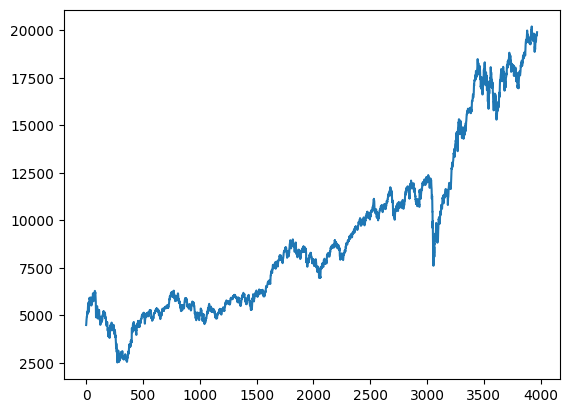

In [102]:
comp_name = '^NSEI' # company for which stocks to be predicted
X, Y = generate_series(data[comp_name], 100)
his1 = data[comp_name].reset_index()['Close']
plt.plot(his1) # plotting the entire data we have(train, validation, test)

In [103]:
from sklearn.preprocessing import MinMaxScaler
scaler = [MinMaxScaler(feature_range=(0, 1)) for _ in range(X.shape[2])]
X = [scaler[i].fit_transform(X[:,:,i]) for i in range(X.shape[2])]
Y = scaler[0].fit_transform(Y.reshape((-1,1)))
X = torch.tensor([[[*k] for k in zip(*sublists)] for sublists in zip(*X)])
X = torch.tensor(X, dtype = torch.float)
Y = torch.tensor(Y, dtype = torch.float)

In [104]:
def split_data(X, Y, p1, p2): # 1-p1-p2 | p1 | p2, train | valid | test
    lookback1 = int(p2*len(X))
    lookback2 = int(p1*len(X))
    X_test = X[-1*lookback1:]
    Y_test = Y[-1*lookback1:]
    X_val = X[-1*(lookback1+lookback2):-1*lookback1]
    Y_val = Y[-1*(lookback1+lookback2):-1*lookback1]
    X_train = X[:-1*(lookback1+lookback2)]
    Y_train = Y[:-1*(lookback1+lookback2)]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [105]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X,Y, 0.1,0.1)

#converting data into tensor batches
from torch.utils.data import DataLoader, TensorDataset

vectorized_train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(vectorized_train_dataset, batch_size=128, shuffle=True)

vectorized_val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(vectorized_val_dataset, batch_size=128, shuffle=False)

## LSTM Model

In [106]:
from torch import nn
from torch.nn import functional as F

class StockPredictor(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden, carry = torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device), torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device)
        output, (hidden, carry) = self.lstm(X_batch)
        return self.linear(self.dropout(output[:,-1, :]))

## Training models like LSTM's, GRU's

In [107]:
def train(model, loss_fn, optimizer, train_loader, val_loader, epochs=10): # training the model using validation and train data
  set_seed(42)
  best_checkpoint = None
  val_prev_loss = 10000000.0
  avg_losses = []
  val_avg_losses = []

  for i in range(1, epochs+1):
    losses = []
    print("Current epoch: ", i)
    model.train()
    ## Training step
    for X, Y in train_loader:
        Y_preds = model(X.to(device))
        loss = loss_fn(Y_preds, Y.to(device))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_losses.append(torch.tensor(losses).mean().item())
    print("Training Loss:", torch.tensor(losses).mean().item())
    ## Validation step
  val_losses = []
  model.eval()
  with torch.no_grad():
      for X, Y in val_loader:
          Y_preds = model(X.to(device))
          loss = loss_fn(Y_preds, Y.to(device))
          val_losses.append(loss.item())
  val_avg_losses.append(torch.tensor(val_losses).mean().item())
  print("Validation Loss:",torch.tensor(val_losses).mean().item())
  ## Selecting best model
  # if torch.tensor(val_losses).mean().item() < val_prev_loss:
      # print("checkpointing current model")
  best_checkpoint = copy.deepcopy(model)
  val_prev_loss = torch.tensor(val_losses).mean().item()
  return best_checkpoint, val_prev_loss, model, avg_losses, val_avg_losses

In [108]:
from torch.optim import Adam

l_epochs = [50,100]
learning_rate = 5e-3
hidden_dim = 32
num_layers=[1,2,3]
input_dim = X_train.shape[2]

avg_loss = 10000000.0
best_checkpoint = 0
avg_losses = [0]
loss_fn = nn.MSELoss().to(device)
for n_layers in num_layers:
  for epochs in l_epochs:
## training using validation and train data
    print("Epochs:", epochs, "Number of lstm layers:", n_layers)
    model = StockPredictor(input_dim, n_layers, hidden_dim).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    best_chck, best_l, last_checkpoint, avg_l, val_l = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)
    print("checkpointing current model")
    if((sum(val_l)/len(val_l)) < avg_loss):
      print("Saving best checkpoint for epochs:", epochs, "layers:", n_layers)
      avg_loss = (sum(val_l)/len(val_l))
      best_checkpoint = best_chck
      avg_losses = avg_l

Epochs: 50 Number of lstm layers: 1
Current epoch:  1
Training Loss: 0.02715587615966797
Current epoch:  2
Training Loss: 0.008023527450859547
Current epoch:  3
Training Loss: 0.002644659485667944
Current epoch:  4
Training Loss: 0.0018108631484210491
Current epoch:  5
Training Loss: 0.001618392881937325
Current epoch:  6
Training Loss: 0.0014696441357955337
Current epoch:  7
Training Loss: 0.0012171614216640592
Current epoch:  8
Training Loss: 0.0011892446782439947
Current epoch:  9
Training Loss: 0.0010037870379164815
Current epoch:  10
Training Loss: 0.0010100840590894222
Current epoch:  11
Training Loss: 0.0008836011402308941
Current epoch:  12
Training Loss: 0.0008264089119620621
Current epoch:  13
Training Loss: 0.0007618474774062634
Current epoch:  14
Training Loss: 0.0007476264145225286
Current epoch:  15
Training Loss: 0.0006859864806756377
Current epoch:  16
Training Loss: 0.0006340680411085486
Current epoch:  17
Training Loss: 0.0006592813297174871
Current epoch:  18
Trainin

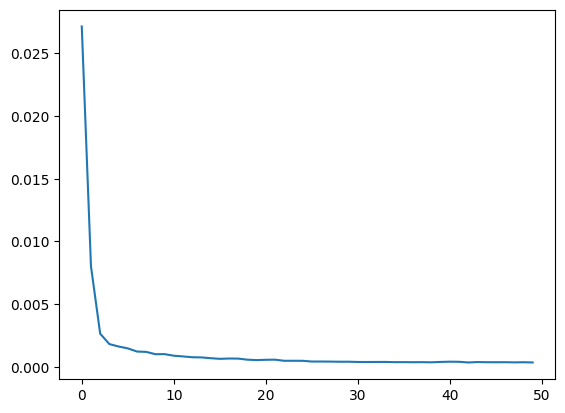

In [109]:
plt.plot(avg_losses) #plot of training losses

##Predicting test data using LSTM

In [110]:
model = best_checkpoint

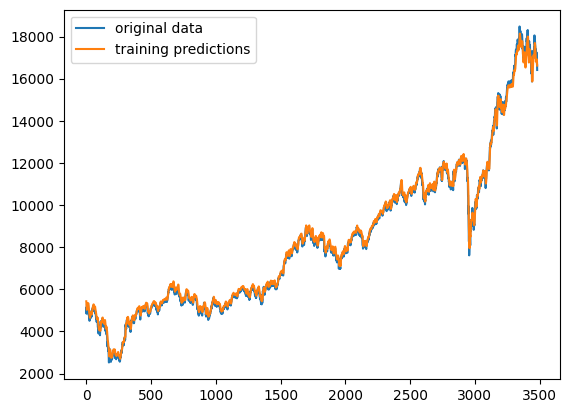

In [111]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [112]:
### Calculate RMSE performance metrics
Y_test = scaler[0].inverse_transform(Y_test)
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("RMSE:", math.sqrt(mean_squared_error(Y_test,closing_price)))
print("MAE:", mean_absolute_error(Y_test,closing_price))
print("MAE:", mean_absolute_percentage_error(Y_test,closing_price))

RMSE: 377.2107760294451
MAE: 337.68974257302824
MAE: 0.018450720624556605


##Plotting predicted data using LSTM

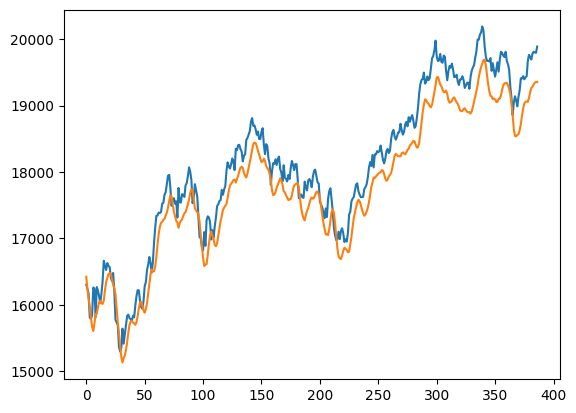

In [113]:
plt.plot(Y_test.tolist())
plt.plot(closing_price)
plt.show()

In [114]:
## Future of stocks for 10 days
num = 10
prices = list(X_test[-1*num])
predicted_prices = []
lol_prices = scaler[0].inverse_transform(model(X_test[-1*num:].to(device)).detach().cpu().reshape((-1,1)))
with torch.no_grad():
    for i in range(num):
        p1 = torch.stack(prices).detach()
        price = model(p1[np.newaxis,:,:].to(device))
        predicted_prices.append(price.cpu())
        prices.pop(0)
        prices.append(torch.Tensor([price, 0])) # dividend is assumed to be zero
a = [Y_test[-1*num].tolist()]
predicted_prices = np.array(predicted_prices)
predicted_prices = scaler[0].inverse_transform(predicted_prices.reshape((-1,1)))
predicted_prices = a + predicted_prices.tolist()
lol_prices = a + lol_prices.tolist()

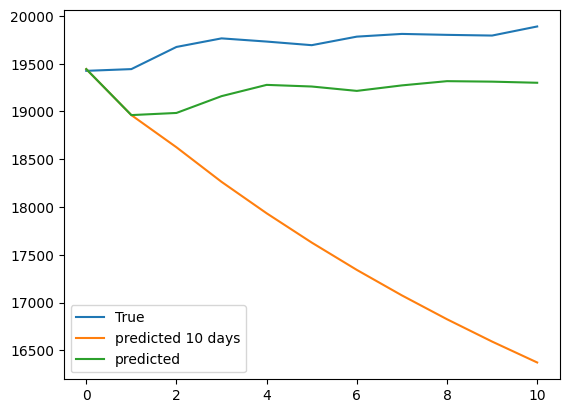

In [127]:
plt.plot(Y_test[-(num+1):].tolist(), label = "True")
plt.plot(predicted_prices, label = "predicted 10 days")
plt.plot(lol_prices, label = "predicted")
plt.legend()
plt.show()

## GRU Model

In [116]:
class StockPredictor_v2(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.num_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden = torch.zeros(self.num_layers, X_batch.size(0), self.hidden_dim).requires_grad_().to(device)
        output, (hidden) = self.gru(X_batch.to(device), (hidden.detach()))
        return self.linear(self.dropout(output[:,-1, :]))

In [117]:
from torch.optim import Adam

l_epochs = [50,100]
learning_rate = 5e-3
hidden_dim = 32
num_layers=[1,2,3]
input_dim = X_train.shape[2]

avg_loss = 10000000.0
best_checkpoint = 0
avg_losses = [0]
loss_fn = nn.MSELoss().to(device)
for n_layers in num_layers:
  for epochs in l_epochs:
## training using validation and train data
    print("Epochs:", epochs, "Number of lstm layers:", n_layers)
    model = StockPredictor_v2(input_dim, n_layers, hidden_dim).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    best_chck, best_l, last_checkpoint, avg_l, val_l = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)
    if((sum(val_l)/len(val_l)) < avg_loss):
      print("Saving best checkpoint for epochs:", epochs, "layers:", n_layers)
      avg_loss = (sum(val_l)/len(val_l))
      best_checkpoint = best_chck
      avg_losses = avg_l

Epochs: 50 Number of lstm layers: 1
Current epoch:  1
Training Loss: 0.023038702085614204
Current epoch:  2
Training Loss: 0.007389374542981386
Current epoch:  3
Training Loss: 0.0017808983102440834
Current epoch:  4
Training Loss: 0.0012239438947290182
Current epoch:  5
Training Loss: 0.001030988758429885
Current epoch:  6
Training Loss: 0.0010191209148615599
Current epoch:  7
Training Loss: 0.0008195044356398284
Current epoch:  8
Training Loss: 0.0008368003182113171
Current epoch:  9
Training Loss: 0.0007662358693778515
Current epoch:  10
Training Loss: 0.0006577164167538285
Current epoch:  11
Training Loss: 0.000663122336845845
Current epoch:  12
Training Loss: 0.0005344701348803937
Current epoch:  13
Training Loss: 0.000575370853766799
Current epoch:  14
Training Loss: 0.0005751319695264101
Current epoch:  15
Training Loss: 0.0005237848381511867
Current epoch:  16
Training Loss: 0.0004927240661345422
Current epoch:  17
Training Loss: 0.0004746083577629179
Current epoch:  18
Trainin

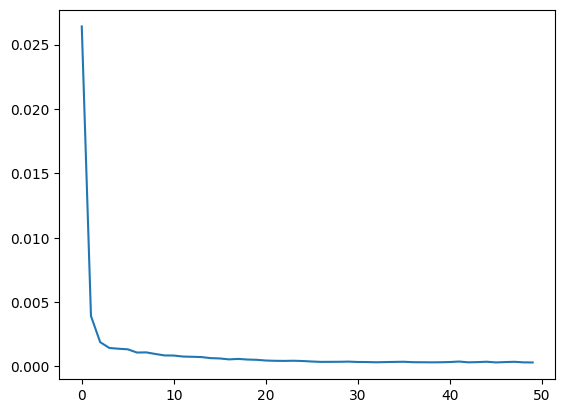

In [118]:
plt.plot(avg_losses) #plot of training losses

##Predicting test data using GRU

In [119]:
model = best_checkpoint

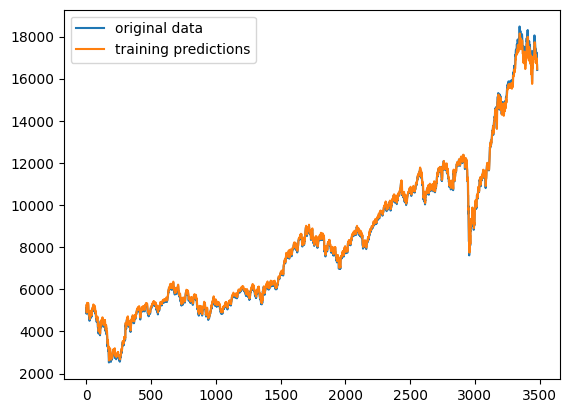

In [120]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [121]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("RMSE:", math.sqrt(mean_squared_error(Y_test,closing_price)))
print("MAE:", mean_absolute_error(Y_test,closing_price))
print("MAE:", mean_absolute_percentage_error(Y_test,closing_price))

RMSE: 367.21072477711317
MAE: 332.6791149839616
MAE: 0.018115741614724255


##Plotting predicted data using GRU


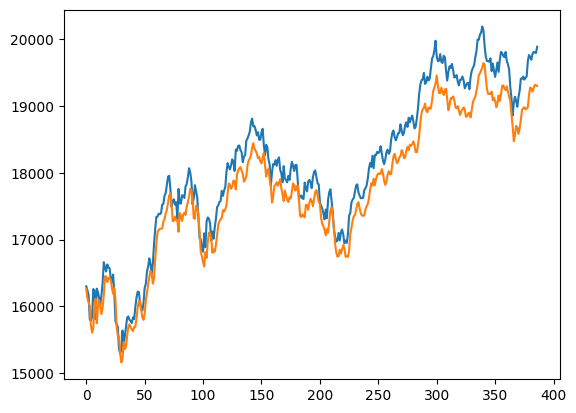

In [122]:
plt.plot(Y_test.tolist(), label='original data')
plt.plot(closing_price, label='Test Predictions')
plt.show()

In [123]:
## Future of stocks for 10 days
num = 10
prices = list(X_test[-1*num])
predicted_prices = []
lol_prices = scaler[0].inverse_transform(model(X_test[-1*num:].to(device)).detach().cpu().reshape((-1,1)))
with torch.no_grad():
    for i in range(num):
        p1 = torch.stack(prices).detach()
        price = model(p1[np.newaxis,:,:].to(device))
        predicted_prices.append(price.cpu())
        prices.pop(0)
        prices.append(torch.Tensor([price, 0])) # dividend is assumed to be zero
a = [Y_test[-1*num].tolist()]
predicted_prices = np.array(predicted_prices)
predicted_prices = scaler[0].inverse_transform(predicted_prices.reshape((-1,1)))
predicted_prices = a + predicted_prices.tolist()
lol_prices = a + lol_prices.tolist()

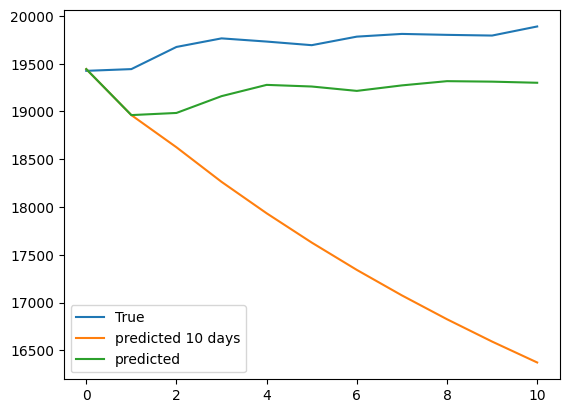

In [126]:
plt.plot(Y_test[-(num+1):].tolist(), label = "True")
plt.plot(predicted_prices, label = "predicted 10 days")
plt.plot(lol_prices, label = "predicted")
plt.legend()
plt.show()